In [3]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
df = pd.read_csv("ransom.csv")
df.head()

,md5,sha1,file_extension,EntryPoint,PEType,MachineType,magic_number,bytes_on_last_page,pages_in_file,relocations,...,total_procsses,files_malicious,files_suspicious,files_text,files_unknown,dlls_calls,apis,Class,Category,Family
0,d5aa2b2506dd71b65307bb551a6a099d,62f4d55a1bb8396e493d7815dc44febed7161535,exe,0x108ec,PE32+,AMD AMD64,MZ,0x0090,0x0003,0x0000,...,0.0,0.0,0.0,0.0,0.0,6.0,162.0,Benign,Benign,Benign
1,8d1178cec97f96a9ede3efe2f30ef30e,ca40945a4e35d48794a5e13aacf16b8ae1caddeb,exe,0x25cf9c,PE32+,AMD AMD64,MZ,0x0090,0x0003,0x0000,...,93.0,0.0,0.0,0.0,0.0,22.0,778.0,Benign,Benign,Benign
2,c08d7afb7966f452cf5aa9283fe8880a,6f47b50480bea61ae4dfb75c12582990cc5ce770,exe,0x2a7e,PE32,"Intel 386 or later, and compatibles",MZ,0x0090,0x0003,0x0000,...,35.0,0.0,0.0,0.0,0.0,1.0,1.0,Benign,Benign,Benign
3,3554a3a99e7ffb57552aedcb2520f1d2,8c3d5b506a8d55f42f4c83ead3e4341255d1acfc,exe,0x64ca0,PE32+,AMD AMD64,MZ,0x0090,0x0003,0x0004,...,0.0,0.0,0.0,0.0,0.0,1.0,40.0,Benign,Benign,Benign
4,5be9511d42136df49d9501680e84109f,0a7d0c68c591db2f197b2169d226bebe6e9bdabe,exe,0x1b9ae,PE32,"Intel 386 or later, and compatibles",MZ,0x0090,0x0003,0x0000,...,36.0,0.0,0.0,0.0,0.0,1.0,1.0,Benign,Benign,Benign


In [5]:
df = df.dropna()

drop_like = ["md5","sha1","file","family","category"]
cols_lower = {c: c.lower() for c in df.columns}
drop_cols = [c for c in df.columns if any(k in cols_lower[c] for k in drop_like)]
df = df.drop(columns=drop_cols, errors="ignore")

label_col = [c for c in df.columns if c.lower() == "class"][0]

y = df[label_col]
X = df.drop(columns=[label_col])

def clean_hex(v):
    if isinstance(v, str):
        m = re.search(r'0x[0-9a-fA-F]+', v)
        if m:
            return int(m.group(), 16)
    return v

for col in X.columns:
    if X[col].dtype == object:
        X[col] = X[col].apply(clean_hex)

for col in X.columns:
    if X[col].dtype == object:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

y = LabelEncoder().fit_transform(y)


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
similarity = np.dot(X_scaled, X_scaled.T)
threshold = np.percentile(similarity, 90)
adj = (similarity > threshold).astype(int)

edge_index = np.array(np.nonzero(adj))
edge_index = torch.tensor(edge_index, dtype=torch.long)


In [8]:
from sklearn.neighbors import kneighbors_graph

knn_graph = kneighbors_graph(X_scaled, n_neighbors=10, mode='connectivity', include_self=False)
edge_index = np.array(knn_graph.nonzero())
edge_index = torch.tensor(edge_index, dtype=torch.long)


In [9]:
from torch_geometric.data import Data

# Convert your processed features and labels to tensors
x_tensor = torch.tensor(X_scaled, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create the Data object
data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)

In [10]:
indices = np.arange(data.num_nodes)
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=42)


In [11]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN(data.num_node_features, 64, 32).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


In [13]:
for epoch in range(15):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()


In [14]:
model.eval()
embeddings = model(data.x, data.edge_index).detach().cpu().numpy()


In [15]:
svm = SVC(kernel="rbf", C=1, gamma="scale")
svm.fit(embeddings[train_idx], y[train_idx])


,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [16]:
import torch.nn.functional as F
from sklearn.metrics import classification_report

# 1. Training with Verbose Output
epochs = 60
print(f"Starting training on {device}...")

for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    out = model(data.x, data.edge_index)
    
    # Calculate loss only on training nodes
    loss = F.cross_entropy(out[train_idx], data.y[train_idx])
    
    loss.backward()
    optimizer.step()
    
    # Print status every 10 epochs
    if epoch % 10 == 0 or epoch == 1:
        model.eval()
        with torch.no_grad():
            # Get predictions for training accuracy
            pred = out[train_idx].argmax(dim=1)
            correct = (pred == data.y[train_idx]).sum().item()
            acc = correct / len(train_idx)
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {acc:.4f}')

# 2. Generate Embeddings for SVM
model.eval()
with torch.no_grad():
    # We use the output of the GCN as the feature set for the SVM
    embeddings = model(data.x, data.edge_index).detach().cpu().numpy()

print("\n--- GCN Training Complete ---")
print(f"Embeddings shape: {embeddings.shape}")

# 3. SVM Classification & Final Report
print("Fitting SVM on GCN embeddings...")
svm = SVC(kernel="rbf", C=1.0)
svm.fit(embeddings[train_idx], y[train_idx])

# Final Evaluation
y_pred = svm.predict(embeddings[test_idx])

print("\nFinal Ransomware Detection Report:")
print(classification_report(y[test_idx], y_pred, target_names=['Benign', 'Ransomware']))

Starting training on cpu...
Epoch: 001, Loss: 0.4388, Train Acc: 0.8404
Epoch: 010, Loss: 0.3823, Train Acc: 0.8454
Epoch: 020, Loss: 0.3499, Train Acc: 0.8573
Epoch: 030, Loss: 0.3337, Train Acc: 0.8600
Epoch: 040, Loss: 0.3207, Train Acc: 0.8663
Epoch: 050, Loss: 0.3101, Train Acc: 0.8720
Epoch: 060, Loss: 0.3010, Train Acc: 0.8760

--- GCN Training Complete ---
Embeddings shape: (21752, 32)
Fitting SVM on GCN embeddings...

Final Ransomware Detection Report:
              precision    recall  f1-score   support

      Benign       0.87      0.88      0.88      2176
  Ransomware       0.88      0.87      0.87      2175

    accuracy                           0.88      4351
   macro avg       0.88      0.88      0.88      4351
weighted avg       0.88      0.88      0.88      4351



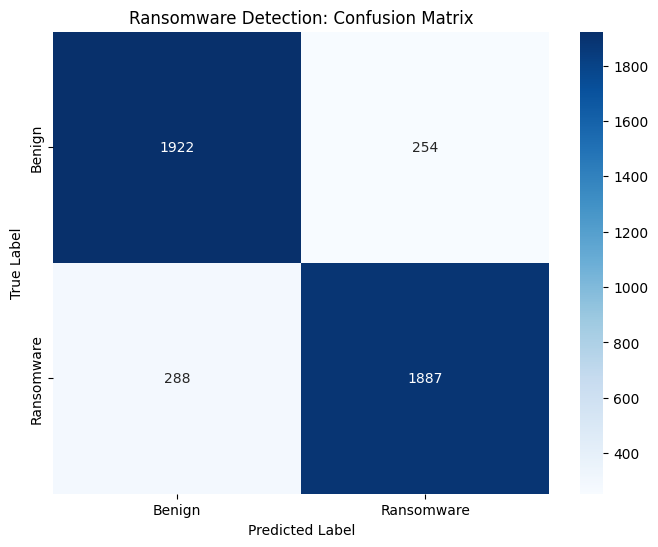

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y[test_idx], y_pred)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Ransomware'], 
            yticklabels=['Benign', 'Ransomware'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Ransomware Detection: Confusion Matrix')
plt.show()

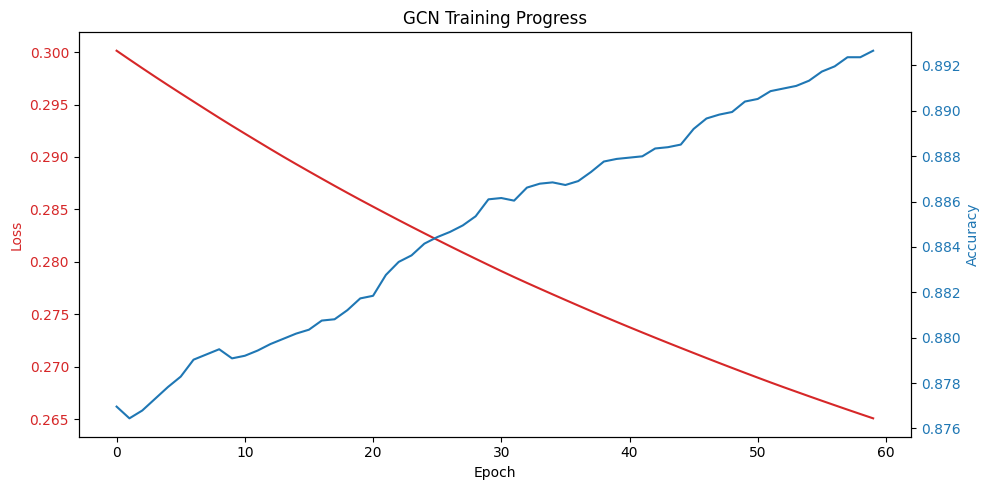

In [18]:
# Updated training loop to store history
history = {'loss': [], 'train_acc': []}

for epoch in range(1, 61):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    
    # Track metrics
    pred = out[train_idx].argmax(dim=1)
    acc = (pred == data.y[train_idx]).sum().item() / len(train_idx)
    history['loss'].append(loss.item())
    history['train_acc'].append(acc)

# Plotting the Learning Curves
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(history['loss'], color='tab:red', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(history['train_acc'], color='tab:blue', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('GCN Training Progress')
fig.tight_layout()
plt.show()

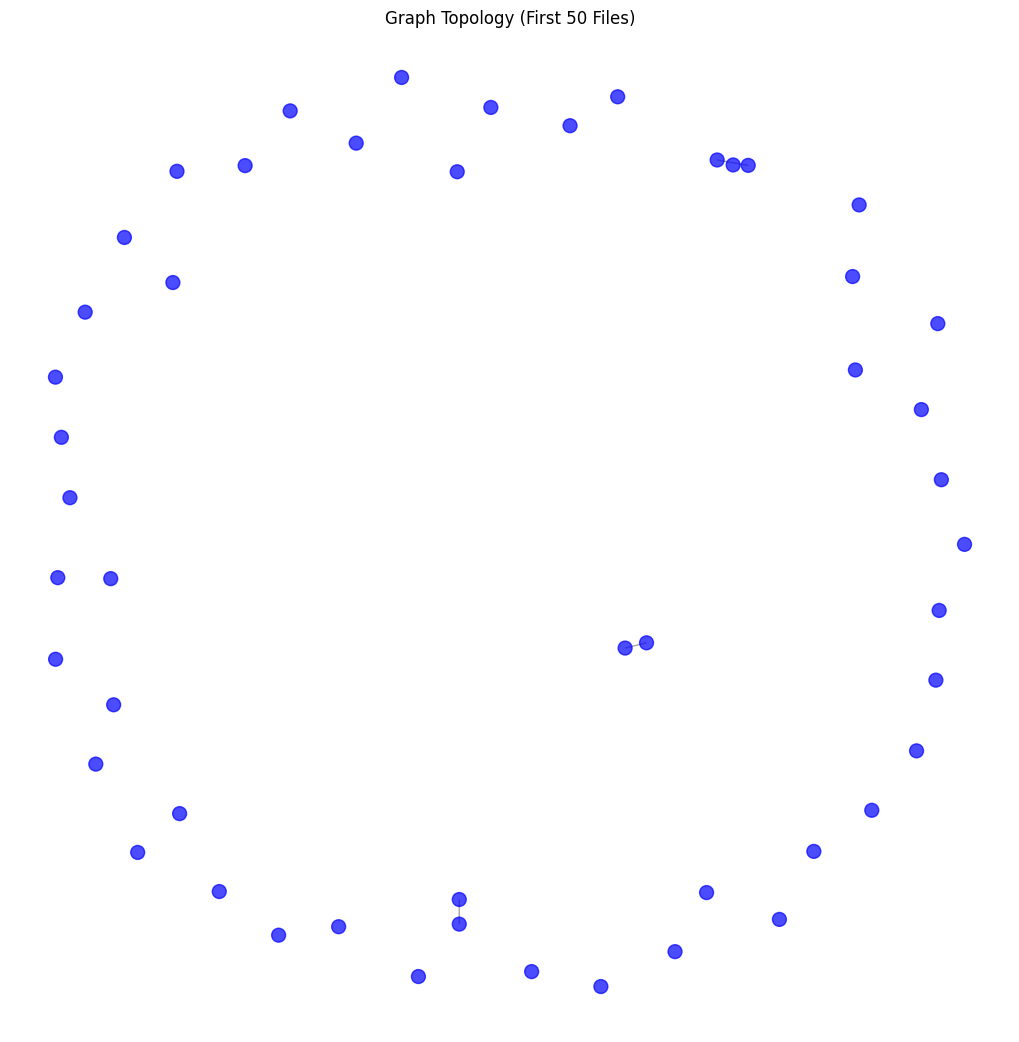

In [19]:
import networkx as nx
from torch_geometric.utils import to_networkx

# Select a small subset of nodes to visualize (otherwise it's too messy)
subset_size = 50
subset_indices = range(subset_size)
sub_data = data.subgraph(torch.tensor(subset_indices))

# Convert to NetworkX
G = to_networkx(sub_data, to_undirected=True)

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)
node_colors = ['blue' if y[i] == 0 else 'red' for i in subset_indices]

nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=100, edge_color='gray', alpha=0.7)
plt.title(f"Graph Topology (First {subset_size} Files)")
plt.show()

In [20]:
import torch

# Define the file path
GCN_PATH = "gcn_ransomware_model.pth"

# Save the state dictionary
torch.save(model.state_dict(), GCN_PATH)
print(f"GCN model weights saved to {GCN_PATH}")

GCN model weights saved to gcn_ransomware_model.pth


In [21]:
import joblib

# Define the file path
SVM_PATH = "svm_ransomware_classifier.pkl"

# Save the trained SVM model
joblib.dump(svm, SVM_PATH)
print(f"SVM model saved to {SVM_PATH}")

SVM model saved to svm_ransomware_classifier.pkl


In [22]:
# Save the scaler
joblib.dump(scaler, "feature_scaler.pkl")

# Save the label encoder if you need to decode 'Benign'/'Ransomware' later
# joblib.dump(label_encoder, "label_encoder.pkl")

['feature_scaler.pkl']

In [23]:
# 1. Define dimensions based on your training configuration
# in_channels must match the number of features in X_scaled
in_channels = X_scaled.shape[1] 

# hidden was set to 64 in your training cell (Cell In[9])
hidden = 64 

# out_channels was set to 32 (Cell In[9])
out_channels = 32 

# 2. Now initialize and load
model = GCN(in_channels, hidden, out_channels)
model.load_state_dict(torch.load(GCN_PATH))
model.eval()
print("GCN model loaded successfully with correct dimensions.")

GCN model loaded successfully with correct dimensions.
